# Traveling Salesman Computer Vision

**Kaggle Dataset**

https://www.kaggle.com/datasets/jeffheaton/traveling-salesman-computer-vision/data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

import tensorflow as tf

import PIL.Image as Image
import os
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2024-05-19 02:57:29.222473: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-19 02:57:29.329802: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 02:57:29.329868: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 02:57:29.332332: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-19 02:57:29.349517: I tensorflow/core/platform/cpu_feature_guar

In [2]:
data_path = r"./tsp-all.csv"
train_data_path = r"./train.csv"

data = pd.read_csv(data_path)
train_data = pd.read_csv(train_data_path)

### Dataset Columns Description

The columns:

- **id**: A unique ID that allows linking across all three CSV files.
- **filename**: The name of each map's image file.
- **distance**: The total distance through the cities, this is the y/label.
- **key**: The generator filename, provides the dimensions, city count, & distance.


In [3]:
data = pd.DataFrame(data)
data

,id,filename,distance,key
0,0,0.jpg,83110,503x673-270-83110.jpg
1,1,1.jpg,1035,906x222-10-1035.jpg
2,2,2.jpg,20756,810x999-299-20756.jpg
3,3,3.jpg,13286,781x717-272-13286.jpg
4,4,4.jpg,13924,609x884-312-13924.jpg
...,...,...,...,...
20018,20019,20019.jpg,7146,376x499-257-7146.jpg
20019,20020,20020.jpg,9695,403x543-348-9695.jpg
20020,20021,20021.jpg,11420,678x497-398-11420.jpg
20021,20022,20022.jpg,15570,739x605-45-15570.jpg


In [4]:
width,height,city_count = [],[],[]
def extract_info(key):
    numbers = re.findall(r'\d+', key) # Use re.findall() to find all sequences of digits
    numbers = list(map(int, numbers)) # convert the list of string numbers to a list of integers
    width.append(numbers[0])
    height.append(numbers[1])
    city_count.append(numbers[2])

for key in data['key']:
    extract_info(key)

In [5]:
data['width'] = width
data['height'] = height
data['city_count'] = city_count

In [6]:
data.describe()

,id,distance,width,height,city_count
count,20023.000000,20023.000000,20023.000000,20023.000000,20023.000000
mean,10011.430405,17788.314788,673.856465,611.027418,203.354942
std,5780.711196,25481.898805,203.361729,238.839623,114.751467
min,0.000000,337.000000,320.000000,200.000000,5.000000
25%,5005.500000,5851.000000,496.000000,405.000000,103.000000
50%,10011.000000,9533.000000,676.000000,610.000000,203.000000
75%,15017.500000,15279.000000,850.000000,820.000000,302.000000
max,20023.000000,180654.000000,1024.000000,1024.000000,999.000000


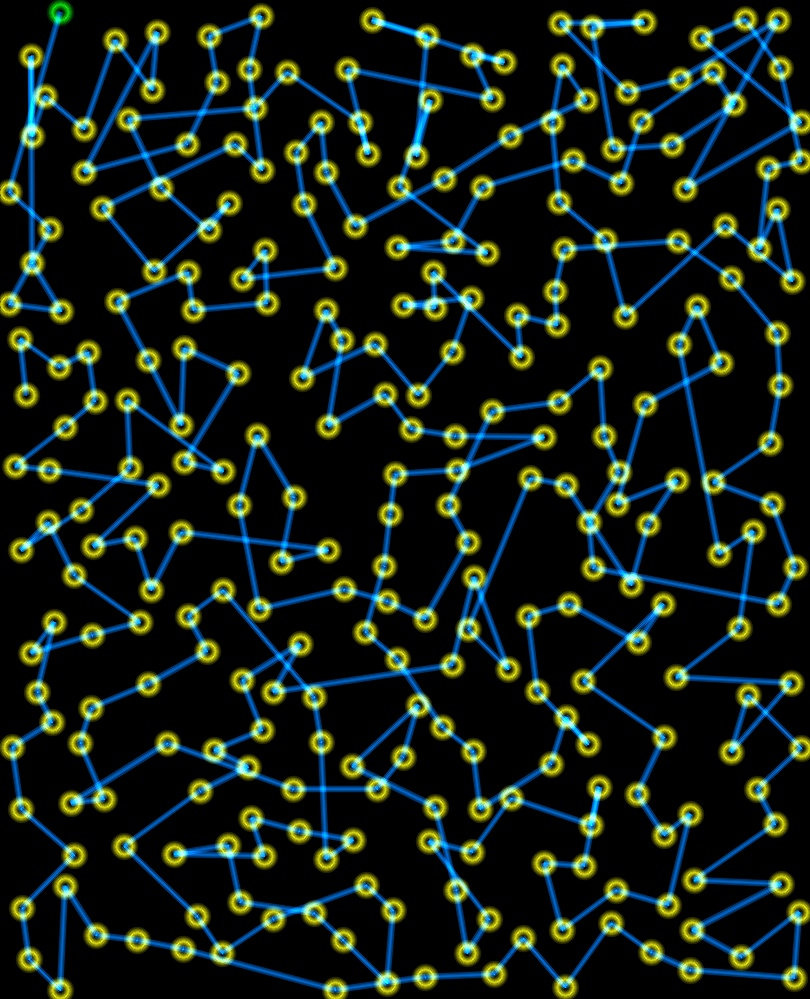

In [7]:
img_path = "./tsp-cv/2.jpg"
img = Image.open(img_path)
img

# Dataset Challenges

This is a regression problem, you are to estimate the total path length. Several challenges to consider:

- **Scaling Maps**: If you indiscriminately scale the maps, you will lose size information.
- **Overlapping Paths**: Paths might overlap, causing the ratio of total pixels to total length to become misleading.
- **Color Brightness**: As paths overlap both other path segments and cities, the resulting color becomes brighter.


## Tackle 1st Problem

**Note**: `max_size = (1024, 1024)`

We will resize all the images to maximize size by using padding. In this way, we will not lose the size information.

In [8]:
def pad_image_to_size(input_image, target_size=(1024, 1024), background_color=(0,0,0)):
    original_image = Image.open(input_image)
    original_width, original_height = original_image.size
    
    # Create a new image with the desired size and background color
    new_image = Image.new("RGB", target_size, background_color)
    
    # Calculate the position to paste the resized image onto the new image
    paste_position = ((target_size[0] - original_width) // 2, (target_size[1] - original_height) // 2)
    
    # Paste the resized image onto the center of the new image
    new_image.paste(original_image, paste_position)
    
    # final resize
    return new_image

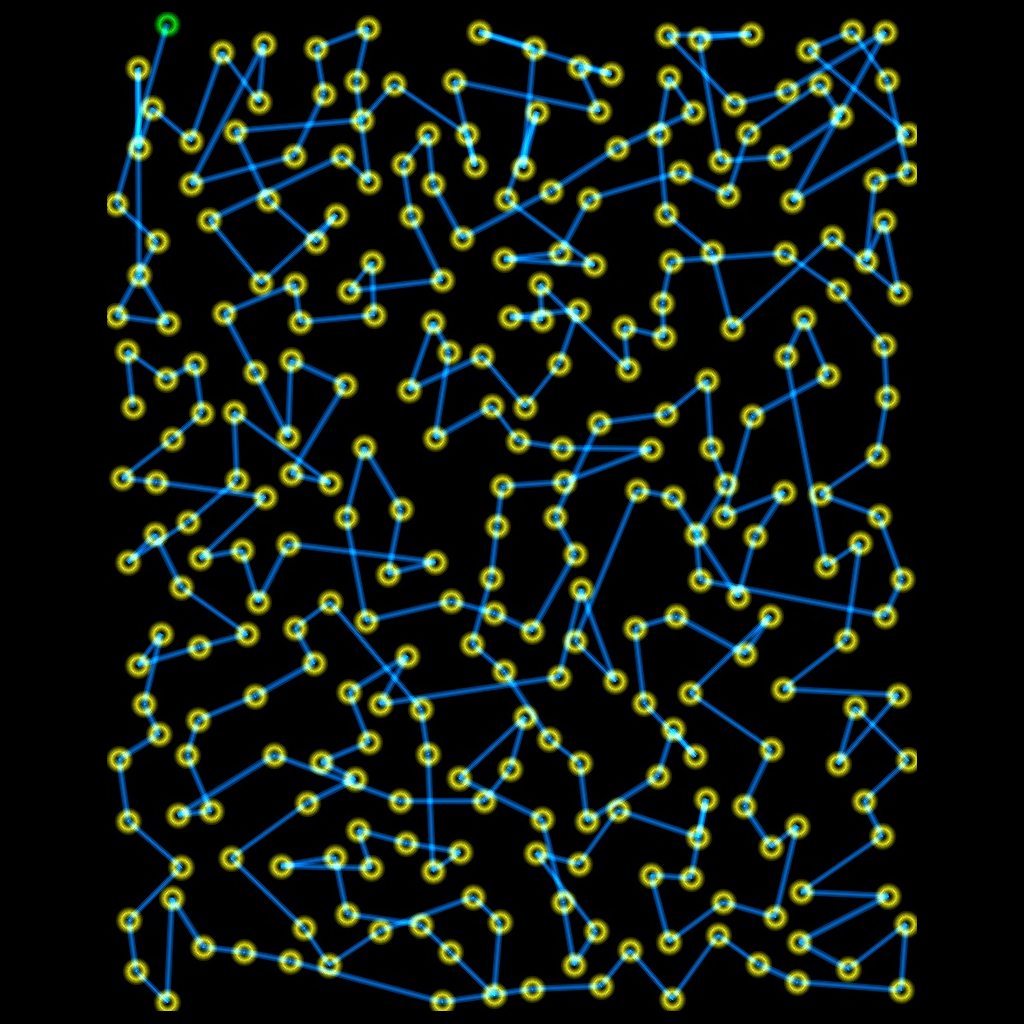

In [9]:
img = pad_image_to_size(img_path)
img



**Problem**:

Resize each to `(1024,1024)` and feeding it to cnn, requires huge computational resources. Hence now we will resize it to `(200,200)`

In [10]:
train_data

,id,filename,distance
0,0,0.jpg,83110
1,1,1.jpg,1035
2,2,2.jpg,20756
3,3,3.jpg,13286
4,4,4.jpg,13924
...,...,...,...
16013,16014,16014.jpg,1803
16014,16015,16015.jpg,12492
16015,16016,16016.jpg,1556
16016,16017,16017.jpg,16507


In [11]:
smallTrainSet = train_data[:5000]

In [12]:
testData = train_data[5000:6000]

In [13]:
smallTrainSet

,id,filename,distance
0,0,0.jpg,83110
1,1,1.jpg,1035
2,2,2.jpg,20756
3,3,3.jpg,13286
4,4,4.jpg,13924
...,...,...,...
4995,4995,4995.jpg,5670
4996,4996,4996.jpg,8990
4997,4997,4997.jpg,4915
4998,4998,4998.jpg,45807


In [14]:
testData

,id,filename,distance
5000,5000,5000.jpg,24640
5001,5001,5001.jpg,15113
5002,5002,5002.jpg,9568
5003,5003,5003.jpg,4918
5004,5004,5004.jpg,64043
...,...,...,...
5995,5995,5995.jpg,6488
5996,5996,5996.jpg,17748
5997,5997,5997.jpg,50663
5998,5998,5998.jpg,23114


In [15]:
def data_prepocess(dataframe):
    X,y = [],[]
    for index, row in dataframe.iterrows():
        img_path = r"./tsp-cv/" + str(row['filename'])
        img = pad_image_to_size(img_path)
        img = img.resize((30,30))
        img_array = np.array(img)
        X.append(img_array)
        # 'distance' is y/label column
        y.append(row['distance'])
    return X,y

In [19]:
X_train,y_train = data_prepocess(smallTrainSet)
X_test, y_test = data_prepocess(testData)

In [20]:
X_train = np.array(X_train)/255 # scaling the images
X_test = np.array(X_test)/255

In [21]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [27]:
def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())
    return r2

In [28]:
model = Sequential([
    # cnn
    layers.Conv2D(filters=16, activation='relu', kernel_size=(3,3), input_shape=(30,30,3)), # kernel_size is the filter size u are using
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=32, activation='relu', kernel_size=(3,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, activation='relu', kernel_size=(3,3)),
    layers.MaxPooling2D((2,2)),
    # ann // dense layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam',
            loss= keras.losses.MeanSquaredError(),
            metrics=[r2_score])

model.fit(X_train,y_train, epochs=10)

Epoch 1/10
157/157 [==============================] - 1s 5ms/step - loss: 496719296.0000 - r2_score: 0.1158
Epoch 2/10
157/157 [==============================] - 1s 4ms/step - loss: 90202928.0000 - r2_score: 0.8259
Epoch 3/10
157/157 [==============================] - 1s 4ms/step - loss: 64289328.0000 - r2_score: 0.8735
Epoch 4/10
157/157 [==============================] - 1s 4ms/step - loss: 42651204.0000 - r2_score: 0.9155
Epoch 5/10
157/157 [==============================] - 1s 4ms/step - loss: 27597580.0000 - r2_score: 0.9500
Epoch 6/10
157/157 [==============================] - 1s 4ms/step - loss: 23750040.0000 - r2_score: 0.9563
Epoch 7/10
157/157 [==============================] - 1s 4ms/step - loss: 21560650.0000 - r2_score: 0.9562
Epoch 8/10
157/157 [==============================] - 1s 4ms/step - loss: 20734154.0000 - r2_score: 0.9606
Epoch 9/10
157/157 [==============================] - 1s 4ms/step - loss: 18745186.0000 - r2_score: 0.9613
Epoch 10/10
157/157 [===============

In [29]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 2ms/step - loss: 16900326.0000 - r2_score: 0.9762


[16900326.0, 0.9761834144592285]

In [30]:
y_pred = model.predict(X_test)

32/32 [==============================] - 0s 2ms/step


In [31]:
results = pd.DataFrame(y_test)

In [32]:
results['y_pred'] = y_pred

In [33]:
results

,0,y_pred
0,24640,26674.808594
1,15113,14376.826172
2,9568,9535.925781
3,4918,3905.412109
4,64043,74815.468750
...,...,...
995,6488,7156.596191
996,17748,18919.291016
997,50663,53321.515625
998,23114,33434.832031


## Results

`r2 score = 0.976` is good